# Introducción

Este notebook actual lleva a cabo una evaluación de rendimiento (speed up) comparando tres distintas implementaciones proporcionadas por PySpark: Dataframes, RDD y SQL. Para lograr esto, efectuamos la lectura de conjuntos de datos que contienen registros de viajes en taxis durante un período específico en la ciudad de Nueva York principalmente se usa la fecha de enero de 2017 para todos los estudios y la de enero, febrero y marzo de 2017 para la evaluacion de rendimiento de un estudio con las diferentes implementaciones.

Con los datos recopilados, se llevarán a cabo diversos análisis con el objetivo de comprender la naturaleza de los datos, identificar sus tipos y extraer información relevante, como la duración promedio de los viajes en taxi por hora y las rutas más frecuentes, entre otros aspectos que se describen posteriormente. A continuación, se presenta una sección que exhibe los resultados del análisis de rendimiento, el cual se llevó a cabo mediante un estudio particular en el que se aplicaron los tres métodos previamente mencionados. Finalmente, se concluye con una evaluación del rendimiento de las tres implementaciones.

El presente notebook fue creado por:
* DAVID SANTIAGO GARCIA CHICANGANA 100508815@alumnos.uc3m.es
* FREDDY RICARDO AQUINO ALIAGA 100461116@alumnos.uc3m.es
* FRANKLIN RAFAEL MEDINA AGUILERA 100515738@alumnos.uc3m.es* 
SEBASTIÁN CRUZ VILLALTA 100516968@alumnos.uc3m.es

El diccionario de datos de este conjunto de datos se puede encontrar en el siguiente enlace: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

Para comenzar, importaremos las bibliotecas necesarias para leer, analizar y visualizar los datos. Principalmente, nos basaremos en las bibliotecas de PySpark.

In [51]:
# Packages for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import pandas as pd

In [90]:
#Reset kernel when start this notebook
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf
from pyspark.sql import Row
import time

In [4]:
def create_spark_session(number_threads):
    spark = SparkSession.builder.master(f'local[{number_threads}]').getOrCreate()
    
    sc = spark.sparkContext
    print("spark session obtained!")
    return spark

def stop_spark_session(session):
    session.stop()
    print("Spark session stopped")

In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 6.6 gigabytes of available RAM



# Lectura de datos

* Debido a que las operaciones en spark son "lazy", necesitamos usar la función show() para ejecutar el computo y ver los resultados

In [8]:
def read_parquet_file(spark_session, path, type, partitions = None):
    sdf = spark_session.read.format(type).option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(path)
    if partitions is not None:
        console.log("repartition executed")
        sdf = sdf.repartition(partitions)
    return sdf

In [66]:
spark_session = create_spark_session('*')
path = "dataset/yellow_tripdata_2017-01.parquet"
sdf = read_parquet_file(spark_session, path, "parquet")
print(f'File read. Number of partitions {sdf.rdd.getNumPartitions()}')

spark session obtained!
File read. Number of partitions 4


In [10]:
#Revisamos el tipo de dao de cada columna
sdf.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: integer (nullable = true)
 |-- airport_fee: integer (nullable = true)



In [11]:
#See the number of records
sdf.count()

9710820

## Valores Null

Antes de realizar los estudios, verificamos la clidad de los datos mediante la identificación de valores nulos.

In [12]:
from pyspark.sql.functions import col, sum, when, expr

In [13]:
# Crea una lista de expresiones que cuentan los valores nulos de cada columna
null_counts = [sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in sdf.columns]

# Aplicar las expresiones al Dataframe y mostrar los resultados
# El '*' es usado para desempacar la lista y pasar cada expresion coomo un argumento por separado
# la funcion agg es para aplicar expresiones al ataframe
sdf.agg(*null_counts).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         

In [38]:
#Las columnas 'congestion_surcharge' y 'airport_fee' contienen valores null, entonces las eliminamos
sdf = sdf.drop(*["congestion_surcharge","airport_fee"])

# Estudio #1 -  Las rutas mas frecuentes

Para analizar los resultados de las rutas, incluimos la información de las zonas para facilitar la lectura y la interpretación e los datos.

In [15]:
path = "dataset/taxi_zone_lookup.csv"
sdf_zones = read_parquet_file(spark_session, path, "csv")
sdf_zones.show()

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

In [16]:
df_filtered = sdf[["PULocationID","DOLocationID","trip_distance","tolls_amount","total_amount"]]
# Cruzamos datos
df_crossdata = df_filtered.join(sdf_zones, col("LocationID") == col("PULocationID"))
# Visualizamos el cruce de los datos. 
df_crossdata.show()

+------------+------------+-------------+------------+------------+----------+---------+--------------------+------------+
|PULocationID|DOLocationID|trip_distance|tolls_amount|total_amount|LocationID|  Borough|                Zone|service_zone|
+------------+------------+-------------+------------+------------+----------+---------+--------------------+------------+
|         140|         236|          1.2|         0.0|         7.8|       140|Manhattan|     Lenox Hill East| Yellow Zone|
|         237|         140|          0.7|         0.0|         6.3|       237|Manhattan|Upper East Side S...| Yellow Zone|
|         140|         237|          0.8|         0.0|         6.8|       140|Manhattan|     Lenox Hill East| Yellow Zone|
|          41|          42|          1.1|         0.0|         7.3|        41|Manhattan|      Central Harlem|   Boro Zone|
|          48|         263|          3.0|         0.0|        12.3|        48|Manhattan|        Clinton East| Yellow Zone|
|         236|  

In [17]:
#Renombramos los datos para no confundirlos con el cruce con los datos de dropoff
df_crossdata = df_crossdata.withColumnRenamed("Borough","borough_pickup")
df_crossdata = df_crossdata.withColumnRenamed("Zone","zone_pickup")
df_crossdata = df_crossdata.withColumnRenamed("service_zone","service_pickup")

In [20]:
# Eliminamos la columna que se añadio para hacer nuevamente el cruce para los datos del dropoff
#Esta celda la ejecutamos dos veces, la primera cuando se cruzan los datos para pickup y la segunda cuando se cruzan datos para el dropoff
df_crossdata = df_crossdata.drop("LocationID")

In [19]:
df_crossdata = df_crossdata.join(sdf_zones, col("LocationID") == col("DOLocationID"))
df_crossdata = df_crossdata.withColumnRenamed("Borough","borough_dropoff")
df_crossdata = df_crossdata.withColumnRenamed("Zone","zone_dropoff")
df_crossdata = df_crossdata.withColumnRenamed("service_zone","service_dropoff")

In [21]:
#Visualizamos el dataset luego de las anteriores operaciones
df_crossdata.show()

+------------+------------+-------------+------------+------------+--------------+--------------------+--------------+---------------+--------------------+---------------+
|PULocationID|DOLocationID|trip_distance|tolls_amount|total_amount|borough_pickup|         zone_pickup|service_pickup|borough_dropoff|        zone_dropoff|service_dropoff|
+------------+------------+-------------+------------+------------+--------------+--------------------+--------------+---------------+--------------------+---------------+
|         140|         236|          1.2|         0.0|         7.8|     Manhattan|     Lenox Hill East|   Yellow Zone|      Manhattan|Upper East Side N...|    Yellow Zone|
|         237|         140|          0.7|         0.0|         6.3|     Manhattan|Upper East Side S...|   Yellow Zone|      Manhattan|     Lenox Hill East|    Yellow Zone|
|         140|         237|          0.8|         0.0|         6.8|     Manhattan|     Lenox Hill East|   Yellow Zone|      Manhattan|Upper 

In [22]:
#Con la información anterior, agrupamos por ruta pickup y dropoff
grouped_sdf = df_crossdata.groupBy("borough_pickup", "borough_dropoff").agg(F.count("total_amount").alias("total_trips")).orderBy(col("total_trips").desc())
grouped_sdf.show()

+--------------+---------------+-----------+
|borough_pickup|borough_dropoff|total_trips|
+--------------+---------------+-----------+
|     Manhattan|      Manhattan|    8209134|
|        Queens|      Manhattan|     297952|
|     Manhattan|         Queens|     291300|
|     Manhattan|       Brooklyn|     281317|
|        Queens|         Queens|     148161|
|       Unknown|        Unknown|     145607|
|      Brooklyn|       Brooklyn|      89365|
|        Queens|       Brooklyn|      75518|
|     Manhattan|          Bronx|      42230|
|      Brooklyn|      Manhattan|      35845|
|       Unknown|      Manhattan|      20018|
|     Manhattan|        Unknown|      17656|
|     Manhattan|            EWR|      14390|
|        Queens|        Unknown|       9636|
|        Queens|          Bronx|       8766|
|      Brooklyn|         Queens|       7317|
|         Bronx|          Bronx|       5154|
|       Unknown|         Queens|       2685|
|         Bronx|      Manhattan|       2222|
|     Manh

La tabla anterior muestra el top 20 de las rutas más frecuentes registradas en enero de 2017. Los viajes en Manhattan ocupan la primera posición y, a partir de dicha posición, aparecen múltiples veces ya sea como zona de recogida o entrega, lo cual evidencia que es una zona con alta afluencia de pasajeros que requieren viajar en taxi.

Adicionalmente, se evidencia ciertas zonas bajo el nombre de Unkown que no permiten conocer a que zona hacen referencia.

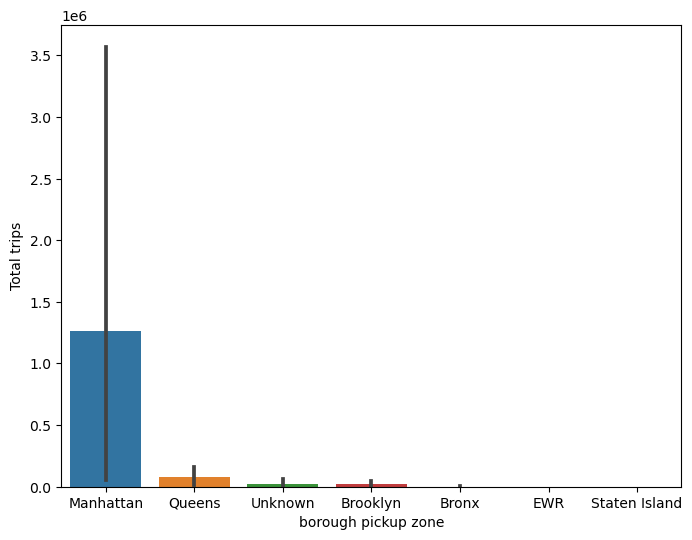

In [23]:
plt.figure(figsize=(8, 6))
result_df_p = grouped_sdf.toPandas()
barplot = sns.barplot(data=result_df_p, x="borough_pickup", y="total_trips")
plt.xlabel("borough pickup zone")
plt.ylabel("Total trips")

# Show the plot
plt.show()

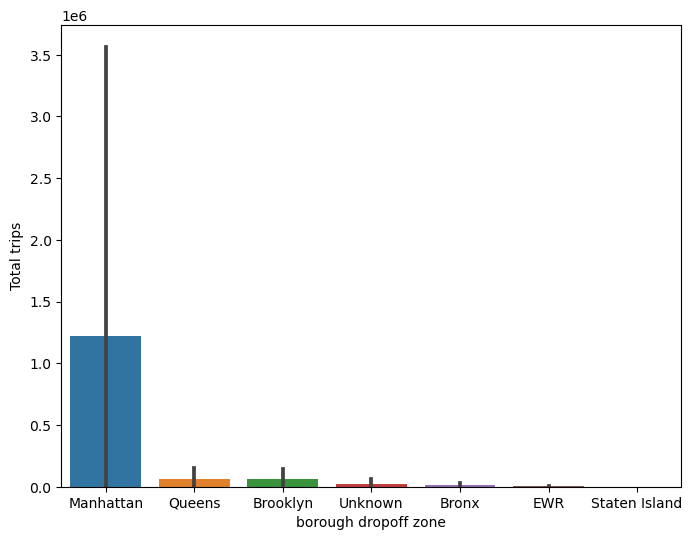

In [24]:
plt.figure(figsize=(8, 6))
result_df_p = grouped_sdf.toPandas()
barplot = sns.barplot(data=result_df_p, x="borough_dropoff", y="total_trips")
plt.xlabel("borough dropoff zone")
plt.ylabel("Total trips")

# Show the plot
plt.show()

# Estudio #2 - Las rutas que mas dinero generaron

Basado en el analisis realizado en la sección anterior, se procedio a calcular las rutas que mas ingresos generaron.

In [25]:
grouped_sdf = df_crossdata.groupBy("borough_pickup", "borough_dropoff").agg(F.sum("total_amount").alias("total_amount"))
#Dividimos entre 100.000 para una mejor visualización
grouped_sdf = grouped_sdf.withColumn("total_amount", col("total_amount") / 100000)
grouped_sdf = grouped_sdf.orderBy(col("total_amount").desc())
grouped_sdf.show()

+--------------+---------------+------------------+
|borough_pickup|borough_dropoff|      total_amount|
+--------------+---------------+------------------+
|     Manhattan|      Manhattan| 984.6744593217379|
|        Queens|      Manhattan|  155.418054599954|
|     Manhattan|         Queens| 116.7562286000072|
|     Manhattan|       Brooklyn| 75.43783349982648|
|        Queens|       Brooklyn|34.656703899978965|
|        Queens|         Queens|31.414253899956726|
|       Unknown|        Unknown|25.504346399995875|
|     Manhattan|        Unknown|13.655903500002227|
|     Manhattan|            EWR|13.426647200001526|
|     Manhattan|          Bronx|13.037575200007414|
|      Brooklyn|       Brooklyn|10.998957400010314|
|      Brooklyn|      Manhattan| 8.172497200001867|
|        Queens|        Unknown| 8.067211300000444|
|        Queens|          Bronx| 4.798081900000567|
|       Unknown|      Manhattan|3.3517394999993173|
|      Brooklyn|         Queens|2.1265201999998786|
|     Manhat

Como podemos ver, las rutas que comenzaron y terminaron en Manhattan fueron las que generaron más dinero. A continuación, Queens a Manhattan y, en tercer lugar, Manhattan a Queens.

# Estudio #3 - Propinas generadas por zona

In [28]:
# Comenzar a medir el tiempo
start_time = time.time()

df_limited = sdf["tip_amount","DOLocationID"]

# Agrupar por 'DOLocationID' y calcular la media de 'tip_amount'
df_avg_tips = df_limited.groupBy("DOLocationID").agg({"tip_amount": "avg"})

# Renombrar columnas para mayor claridad
df_avg_tips = df_avg_tips.withColumnRenamed("avg(tip_amount)", "average_tip")

# Si quieres ordenar por la media de propina de mayor a menor:
df_avg_tips_ordered = df_avg_tips.orderBy("average_tip", ascending=False)

df_avg_tips_ordered.show()

# Finalizar medición del tiempo
end_time = time.time()
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time:.2f} segundos.")

+------------+------------------+
|DOLocationID|       average_tip|
+------------+------------------+
|         204|15.657611940298507|
|          44|12.607241379310345|
|           2|12.126249999999999|
|           1|10.954543615676386|
|         109| 10.73825581395349|
|         176|10.382933333333337|
|          84| 9.383253012048192|
|           5| 9.147704918032787|
|         265| 8.874212609556167|
|         214| 8.320777777777776|
|         245| 8.035326086956523|
|          23| 7.677205240174674|
|         172| 7.591983471074382|
|         251| 7.571948051948051|
|         118| 7.352035928143712|
|         206|7.0175956284152985|
|         132| 6.725178089023828|
|           6| 6.120670103092784|
|         156| 5.911585365853658|
|         138|  5.85998675301736|
+------------+------------------+
only showing top 20 rows

Tiempo de ejecución: 1.54 segundos.


# Estudio #4 - Velocidad promedio en cada hora

Este estudio siguiente describe la implementación de los tres métodos mencionados inicialmente. Comenzaremos con el procesamiento de Dataframes, seguido por RDD y, finalmente, SQL.

In [43]:
#Realizamos las importaciones necesarias para las operaciones del presente estudio
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import hour, avg, max, min

## Metodo 1 - Dataframe

In [39]:
#Calculamos la diferencia de tiempo entre pickup y dropoff
sdf = sdf.withColumn("duration", col("tpep_dropoff_datetime")-col("tpep_pickup_datetime"))
#sdf.select("duration").show()

### Verificar la duración de los viajes

In [40]:
#convertir a segundos manualmente a través de funciones definidas por el usuario (UDF)
def interval_to_seconds(interval):
    total_seconds = interval.total_seconds()
    return int(total_seconds)

interval_to_seconds_udf = udf(interval_to_seconds, IntegerType())

In [41]:
# Utilizamos la UDF para extraer segundos y almacenarlos en una nueva columna
sdf = sdf.withColumn("duration", interval_to_seconds_udf(col("duration")))
#sdf.select("duration").show()

In [42]:
#Verificamos valores
sdf.filter(col("duration") < 0).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|duration|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
|       1| 2017-01-10 15:15:25|  2017-01-06 00:23:28|              1|          3.0|         1|                 N|         246|         239|           1|       13.0|  0.0|    0.5|      2.75|         0.0|                  0.3|       16.55| -399117|
|       1| 2

In [ ]:
sdf.filter(col("duration") == 0).show()

Todos los registros anteriores muestran que los viajes terminaron al mismo tiempo que comenzaron.

Debido a todos estos registros, procedemos a eliminarlos.

In [ ]:
sdf = sdf.filter(col("duration") > 0)
size_after_reduction = sdf.count()
print(f"Size of the sample '{size_after_reduction}'")

### Calcular la velocidad de cada viaje

In [ ]:
#Como la columna de duración está en segundos, tenemos que dividir el valor entre 3600 para pasarlas a horas
sdf = sdf.withColumn("velocity",col("trip_distance")/(col("duration")/3600))
sdf.select("velocity").show()

*Las unidades de velocidad estan en millas por hora

### Calculamos el promedio de la velocidad por hora

In [ ]:
sdf = sdf.withColumn("hour_pickup", hour(col("tpep_pickup_datetime")))
sdf = sdf.withColumn("hour_dropoff", hour(col("tpep_dropoff_datetime")))
sdf.show()

In [ ]:
result_df = sdf.groupBy("hour_pickup").agg(avg("velocity").alias("VelocityAvg")).orderBy("hour_pickup")

result_df.show(24)

### Visualización de resultados

In [ ]:
plt.figure(figsize=(10, 6))
result_df_p = result_df.toPandas()
barplot = sns.barplot(data=result_df_p, x="hour_pickup", y="VelocityAvg")
plt.xlabel("Hour")
plt.ylabel("Average velocity")

# Show the plot
plt.show()

### Resumen

Las siguientes dos celdas fueron las utilizadas para la medición del tiempo. Contienen todas las operaciones del estudio 4 de una manera mas concreta

In [78]:
#Operations reduced
from pyspark.sql.functions import hour, udf, avg, col
from pyspark.sql.types import IntegerType, StringType

#convert to seconds manually through User defined functions (UDF)
def interval_to_seconds(interval):
    total_seconds = interval.total_seconds()
    return int(total_seconds)

interval_to_seconds_udf = udf(interval_to_seconds, IntegerType())

# START THE TIMER
DFstarttime = time.time()
sdfDF = sdf.withColumn("duration", col("tpep_dropoff_datetime")-col("tpep_pickup_datetime"))
sdfDF = sdfDF.withColumn("duration", (interval_to_seconds_udf(col("duration")) / 3600))
sdfDF = sdfDF.filter(col("duration") > 0)
sdfDF = sdfDF.withColumn("velocity",col("trip_distance")/col("duration"))
sdfDF = sdfDF.withColumn("hour_pickup", hour(col("tpep_pickup_datetime")))
sdfDF = sdfDF.withColumn("hour_dropoff", hour(col("tpep_dropoff_datetime")))

result_df = sdfDF.groupBy("hour_pickup").agg(avg("velocity").alias("VelocityAvg")).orderBy("hour_pickup")
result_df.show(24)
#STOP TIMER
DFendtime = time.time()

+-----------+------------------+
|hour_pickup|       VelocityAvg|
+-----------+------------------+
|          0|17.135377162085373|
|          1|  17.7084494704235|
|          2|18.005655850937046|
|          3|18.156252751944653|
|          4| 20.76540968125122|
|          5| 22.53105310024046|
|          6|18.062101710891028|
|          7|13.693853937236215|
|          8|11.674041169497219|
|          9|11.739438524116354|
|         10| 12.19164877672022|
|         11|11.970101055787831|
|         12|12.047918921365886|
|         13|12.541032414917348|
|         14|11.874196223496451|
|         15|11.606618169769838|
|         16|12.391826175756417|
|         17|11.713800892106143|
|         18| 11.60556837151269|
|         19|12.547998876114262|
|         20|13.913271912840372|
|         21|  15.1267632937441|
|         22|15.818566971052546|
|         23|17.170343696303483|
+-----------+------------------+



In [79]:
ExecTime = DFendtime - DFstarttime 
print(ExecTime)

45.459200859069824


## RDD

In [80]:
RDDstarttime = time.time()

# Filtra las columnas que tengan campos Nulls y filtra filas que tengan tiempos Cero entre la diferencia de Llegada y Recogida
filtered = sdf.rdd.filter(lambda x: x[1] is not None and x[2] is not None and x[4] is not None).filter(lambda x: (x[2] - x[1]).seconds > 0)

# Hace un mapeo de la hora recogida, la velocidad en la hora y un contador
mapped = filtered.map(lambda x: (x[1].hour, (x[4]/(((x[2] - x[1]).seconds)/3600), 1)))

# Realiza el Reduce en Referencia a la hora y Sumando Contador y Velocidades
result = mapped.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

# Obtiene los promedios de las velocidades por hora y los muestra en pantalla
result.map(lambda x: (x[0], x[1][0] / x[1][1] )).sortBy(lambda x: x[0], True).take(24)

RDDendtime = time.time()

In [ ]:
ExecTime = RDDendtime - RDDstarttime 
print(ExecTime)

## SQL

In [90]:
SQLstarttime = time.time()
#Los datos leídos los sube a memoria en una tabla temporal
sdf.createOrReplaceTempView('tabledataset')

#Let's calculate the difference of time between the pick-up and the drop-off in seconds
#Difference DateTime
#Velocity
#Hour from tpep_pickup_datetime
#Hour from tpep_dropoff_datetime
# In Where filter Values dropoff>pickup
dfsqlreduce = spark.sql("""SELECT *,
                                (unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime)) AS difference_datetime,
                                trip_distance/(( (unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime))/60 )/60) AS velocity,
                                HOUR(tpep_pickup_datetime) AS pickup_hour,
                                HOUR(tpep_dropoff_datetime) AS dropoff_hour
                            FROM tabledataset
                            WHERE tpep_dropoff_datetime > tpep_pickup_datetime
                        """) 

#Calculate the velocity avg of each hour
#dfsqlreduce_avg = dfsqlreduce
dfsqlreduce.createOrReplaceTempView('tabledataset2')
dfsqlreduce_avg = spark.sql("""SELECT 
                                pickup_hour,
                                sum(velocity) as sumvelocity,
                                count(velocity) as countvelocity,
                                avg(velocity) as hourly_average        
                            FROM tabledataset2
                            GROUP BY pickup_hour
                            ORDER BY pickup_hour ASC
                            """) 
dfsqlreduce_avg.show(24)
SQLendtime = time.time()

In [ ]:
ExecTime = SQLendtime - SQLstarttime 
print(ExecTime)

# Analisis de rendimiento (speedup)

Para realizar este analisis, realizamos los siguientes pasos con cada uno de los metodos implementados en el "Estudio #4 - Velocidad promedio en cada hora"

1.  Llevamos a cabo la medición del tiempo de las operaciones clave en el estudio anteriormente mencionado. Esto implica que no incluimos las operaciones como la lectura de datos en la medición del tiempo, sino que nos enfocamos en las operaciones encargadas de filtrar, agrupar y realizar otras tareas necesarias para el estudio en cuestión.
2.  Cada ejecución fue realizada con un numero de cores diferente. Para nuestro caso, se realizo en una maquina con 8 cores fisicos y 8 virtuales para un total de 16 cores. Este mismo proceso fue realizado con cada uno de los metodos asegurandonos de que realizarán las mismas operaciones sobre el mismo conjunto de datos.
3.  Con los tiempos obtenidos por cada uno de los metodos procedimos a calcular el speed up de la siguiente manera:

    Speed up = Tiempo sequencial* / tiempo paralelizado
    
    *Se tomo como el tiempo obtenido al ejecutar sobre un core.
    
5.  Los datos del speed up fueron graficados y contrastados con cada uno de los metodos para evaluar su desempeño.
6.  Adicionalmente, se utilizaron diferentes tamaños de dataset para observar el comportamiento ante un mayor numero de registros.

Los resultados de este proceso se describen a continuación

## Primer dataset - Mas de 9 millones de registros

El primer dataset empleado para el analisis consistio en un conjunto de datos con mas de 9 millones de registros. Los datos fueron leidos y procesados segun las operaciones presentadas en la primera sección de este notebook (Lectura de datos). Los datos de tiempo registrados y el speed up calculado con este dataset se pueden observar en la siguiente tabla.

<img src=https://raw.githubusercontent.com/Tisandg/HPCComparation/main/imagenes/1_dataset.jpg>

Inicialmente se observa que el tiempo de ejecución en los diferentes metodos varian significativamente. Dataframe tomo alrededor de 42 segundos en realizar los computos del estudio, RDD alrededor de 100 segundos y, finalmente, SQL tuvo un mejor desempeño tomando alrededor de un segundo y medio. Estas comparacinoes se realizaron con las mismas variables de dataset como de cores.

Una de las expectativas iniciales fue que al aumentar el numero de cores resultaria en un menor tiempo de ejecución. Sin embargo, se evidencia que los valores obtenidos en cada uno de los metodos no varian significativamente (Esto se puede observar en la grafica siguiente). Para el caso de de Dataframe, inicio con un valor de 42,56 segundos (1 core) y termino con un valor de 44,06 (16 cores), RDD obtuvo inicio con 102 segundos y termino con 101,91 segundos, y, SQL, empezo con 1.68 segundos y finalizo con 1,65 segundos.

Con respecto al speedup, observamos numeros variantes que sobrepasan y disminuyen desde el punto inicial (1) lo cual no se alinea con la expectativa, con sql va de un minimo de 0.923 a un maximo de 1.077, con rdd va de 0.920 a 1.018, y con dataframe desde 0.950 hasta 1.025 respectivamente.

In [76]:
#Data
data_first = {
    'cores': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
    'dataframe_time': [42.56, 44.00, 41.64, 42.05, 43.16, 41.54, 41.71, 42.51, 42.73, 42.48, 42.09, 43.51, 43.34, 44.79, 43.17, 44.06],
    'rdd_time': [102.13,100.36,100.81,100.87,100.81,100.58,100.88,100.34,107.19,101.44,110.97,108.78,101.18,109.95,101.57,101.91],
    'sql_time': [1.68,1.72,1.59,1.56,1.84,1.82,1.59,1.61,1.61,1.61,1.69,1.72,1.81,1.83,1.65,1.65],
    'dataframe_speedup': [1.000,0.967,1.022,1.012,0.986,1.025,1.020,1.001,0.996,1.002,1.011,0.978,0.982,0.950,0.986,0.966],
    'rdd_speedup': [1.000,1.018,1.013,1.012,1.013,1.015,1.012,1.018,0.953,1.007,0.920,0.939,1.009,0.929,1.006,1.002],
    'sql_speedup': [1.000,0.977,1.057,1.077,0.913,0.923,1.057,1.043,1.043,1.043,0.994,0.977,0.928,0.918,1.018,1.018],
}
df_1 = pd.DataFrame(data_first)

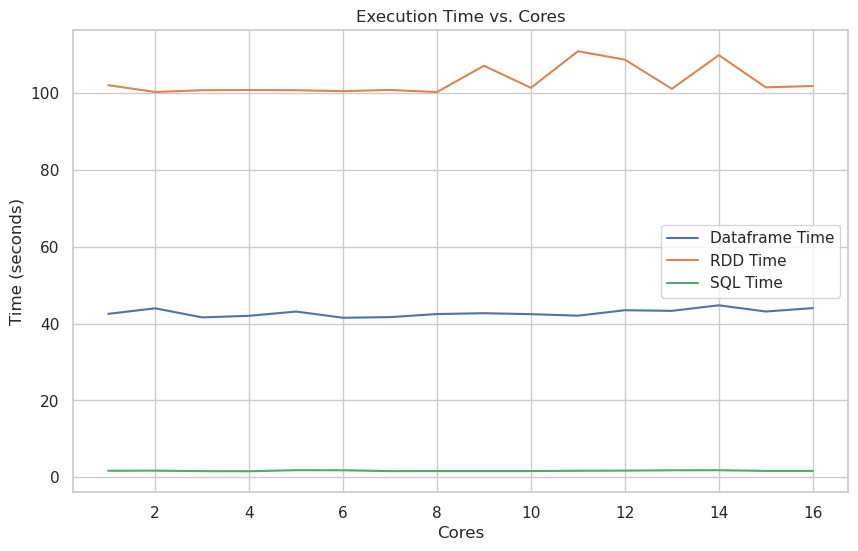

In [77]:
#Visualización
plt.figure(figsize=(10, 6))
sns.lineplot(x='cores', y='dataframe_time', data=df_1, label='Dataframe Time')
sns.lineplot(x='cores', y='rdd_time', data=df_1, label='RDD Time')
sns.lineplot(x='cores', y='sql_time', data=df_1, label='SQL Time')

plt.xlabel('Cores')
plt.ylabel('Time (seconds)')
plt.title('Execution Time vs. Cores')

plt.legend()

plt.show()

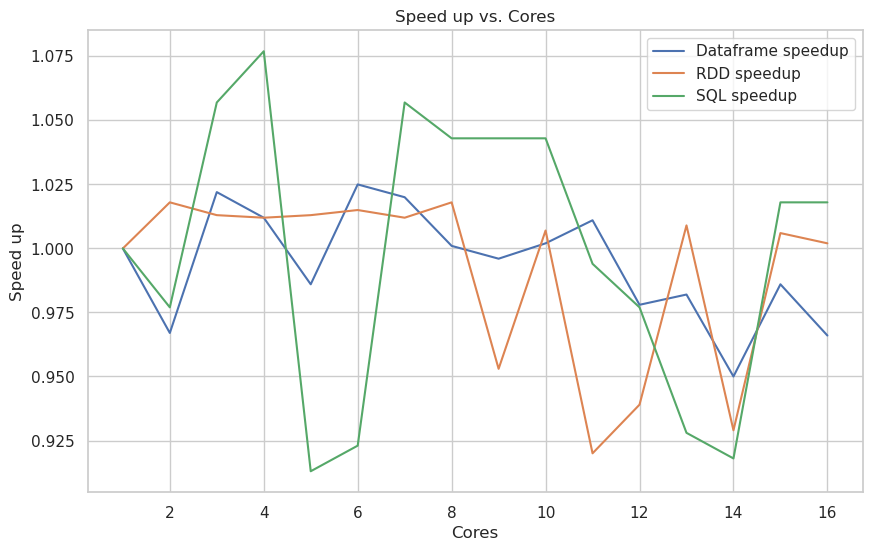

In [78]:
#Visualizacion
plt.figure(figsize=(10, 6))
sns.lineplot(x='cores', y='dataframe_speedup', data=df_1, label='Dataframe speedup')
sns.lineplot(x='cores', y='rdd_speedup', data=df_1, label='RDD speedup')
sns.lineplot(x='cores', y='sql_speedup', data=df_1, label='SQL speedup')

plt.xlabel('Cores')
plt.ylabel('Speed up')
plt.title('Speed up vs. Cores')

plt.legend()

plt.show()

Al visualizar los datos en la grafica, no se observa un patron en los diferentes metodos. A medida que se aumenta el numero de cores, se presentan puntos bajos y altos sin ninguna tendencia clara.

Por lo anterior, decidimos aumentar el numero de datos para observar su comportamiento de los metodos ante un mayor numero de registros. Esto con el fin de incrementar el numero de tareas y su granularidad. De esta manera, obtener una mejor comparativa.

## Resultados del segundo dataset

<img src=https://raw.githubusercontent.com/Tisandg/HPCComparation/main/imagenes/2_dataset.jpg>


Para este caso, se conto un un dataset de mas de 18 millones de registros. Al ejecutar el proceso descrito anteriormente, podemos observar que:
* En el tiempo de ejecución, tenemos datos similares respecto al punto anterior con variaciones en algunos de ellos. Sin embargo, al visualizar la grafica, se puede observar un patron mas claro en los datos. Para el caso del RDD y SQL time, se observa que iniciaron con tiempo de ejecución relativamente altos (RDD con valor cercano a 200, dataframe con un valor de 81 y sql con 3,53) pero al aumentar el numero de cores, especificamente a 2, disminuyo el tiempo y se mantuvo el tiempo de ejecución a medida que aumentaban los cores.
* El speed up incrementa sustancialmente cuando el numero de cores son 2 (Grafica speed up vs cores). A partir de este punto, se ve una leve tendencia a la baja en los tres metodos pero con diferencias notables en la implementación de SQL. En general, dataframe y RDD varian de manera leve a medida que los cores aumentan. Sin embargo, en el caso de SQL, tiene picos altos y bajos que varian drasticamente, especialmente cuando hay 8 y 10 cores. Como nota general, se observa un pico alto cuando la ejecución fue realizada con 15 cores y un descenso notorio en el speed up cuando fue ejecutado con todos los cores de la maquina utilizada.

In [79]:
#Data
data_second = {
    'cores': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
    'dataframe_time': [81.36,48.53,47.87,49.11,49.21,55.45,49.95,51.97,51.20,51.08,49.47,52.27,53.50,56.00,49.49, 53.84],
    'rdd_time': [199.87,107.97,104.27,103.93,106.43,110.40,109.15,105.65,106.04,108.08,110.84,113.47,117.58,118.52,107.53,111.71],
    'sql_time': [3.53,2.13,1.99,1.99,2.06,2.15,2.09,2.81,2.15,2.79,2.13,2.15,2.45,2.19,2.16,3.99],
    'dataframe_speedup': [1.000, 1.676,1.700,1.657,1.653,1.467,1.629,1.566,1.589,1.593,1.645,1.557,1.521,1.453,1.644,1.511],
    'rdd_speedup': [1.000,1.851,1.917,1.923,1.878,1.810,1.831,1.892,1.885,1.849,1.803,1.761,1.700,1.686,1.859,1.789],
    'sql_speedup': [1.000,1.657,1.774,1.774,1.714,1.642,1.689,1.256,1.642,1.265,1.657,1.642,1.441,1.612,1.634,0.885],
}
df_2 = pd.DataFrame(data_second)

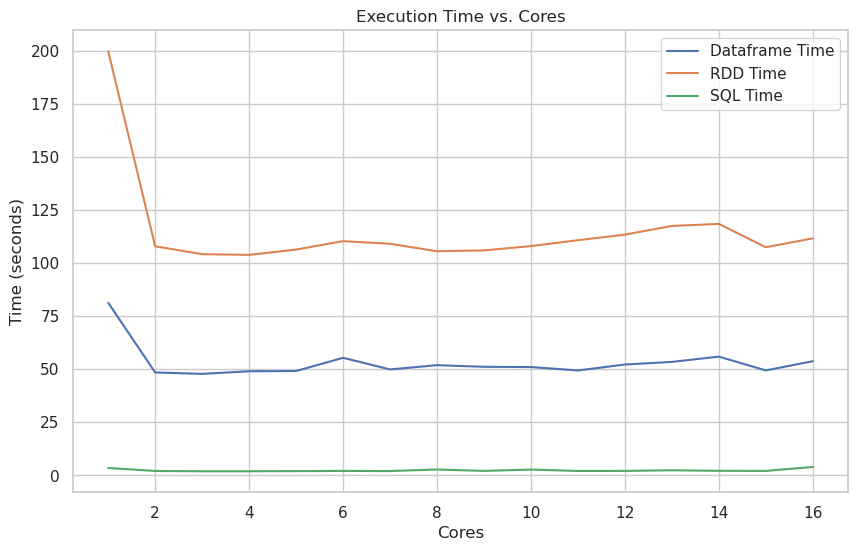

In [81]:
#Visualización
plt.figure(figsize=(10, 6))
sns.lineplot(x='cores', y='dataframe_time', data=df_2, label='Dataframe Time')
sns.lineplot(x='cores', y='rdd_time', data=df_2, label='RDD Time')
sns.lineplot(x='cores', y='sql_time', data=df_2, label='SQL Time')

plt.xlabel('Cores')
plt.ylabel('Time (seconds)')
plt.title('Execution Time vs. Cores')

plt.legend()

plt.show()

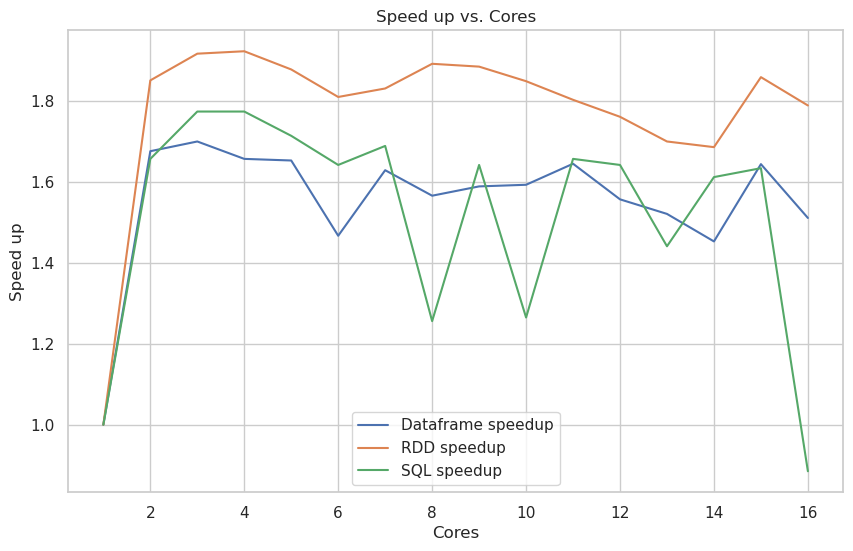

In [82]:
#Visualizacion
plt.figure(figsize=(10, 6))
sns.lineplot(x='cores', y='dataframe_speedup', data=df_2, label='Dataframe speedup')
sns.lineplot(x='cores', y='rdd_speedup', data=df_2, label='RDD speedup')
sns.lineplot(x='cores', y='sql_speedup', data=df_2, label='SQL speedup')

plt.xlabel('Cores')
plt.ylabel('Speed up')
plt.title('Speed up vs. Cores')

plt.legend()

plt.show()

Para aumentar el numero de pruebas con las implementaciones, aumentamos el numero de datos con un dataset de alrededor de 29 millones de registros. 

## Resultados con el tercer dataset

Description

<img src=https://raw.githubusercontent.com/Tisandg/HPCComparation/main/imagenes/3_dataset.jpg>


En este caso final, se destaca lo siguiente:
* En la grafica "execution time vs cores" se observa un comportamiento similar al registrado con el segundo dataset. Las implementaciones de RDD y Datafame comienzan a descender notoriamente cuando el numero de cores es disminuido. Sin embargo, a partir de 3 cores, su comportamiento se mantiene similar y solo vaira cuando son ejecutados a partir de 14 cores. En el caso de SQL, su tiempo de ejecución fue realizado en un tiempo considerablemente menor a los otros dos metodos y se mantuvo constante con ligeras cambios al inicio y al final de la grafica.

Descrition

In [87]:
#data
data_third = {
    'cores': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
    'dataframe_time': [125.92,91.32,58.60,61.27,59.86,59.45,59.51,62.17,61.46,60.25,59.97,60.22,60.98,62.87,49.49,53.84],
    'rdd_time': [199.87,202.76,119.60,120.07,124.44,122.22,125.16,120.91,121.97,127.74,118.14,122.37,127.28,126.32,107.53,111.71],
    'sql_time': [3.53,3.95,2.30,2.43,2.24,2.30,2.56,2.40,2.51,2.42,2.45,2.39,2.57,2.33,2.16,3.99],
    'dataframe_speedup': [1.000,1.379,2.149,2.055,2.104,2.118,2.116,2.025,2.049,2.090,2.100,2.091,2.065,2.003,2.544,2.339],
    'rdd_speedup': [1.000,0.986,1.671,1.665,1.606,1.635,1.597,1.653,1.639,1.565,1.692,1.633,1.570,1.582,1.859,1.789],
    'sql_speedup': [1.000,0.894,1.535,1.453,1.576,1.535,1.379,1.471,1.406,1.459,1.441,1.477,1.374,1.515,1.634,0.885],
}
df_3 = pd.DataFrame(data_third)

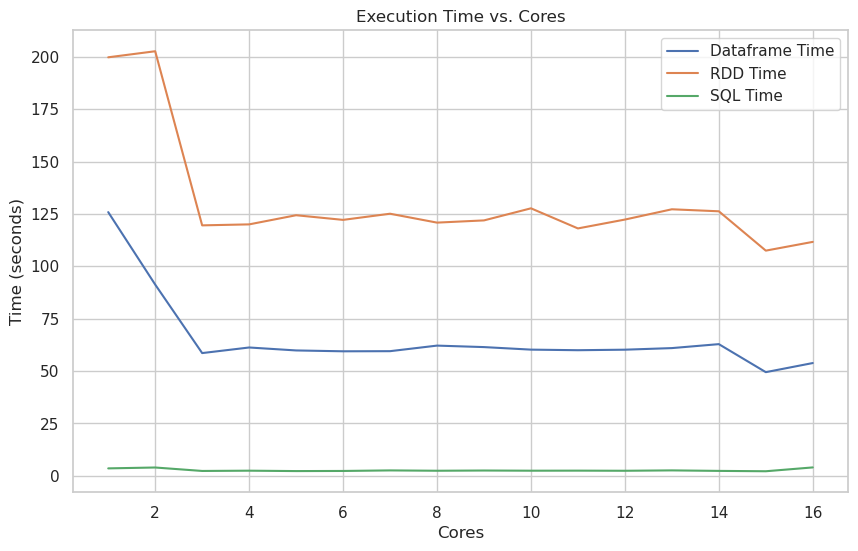

In [88]:
#Visualización
plt.figure(figsize=(10, 6))
sns.lineplot(x='cores', y='dataframe_time', data=df_3, label='Dataframe Time')
sns.lineplot(x='cores', y='rdd_time', data=df_3, label='RDD Time')
sns.lineplot(x='cores', y='sql_time', data=df_3, label='SQL Time')

plt.xlabel('Cores')
plt.ylabel('Time (seconds)')
plt.title('Execution Time vs. Cores')

plt.legend()

plt.show()

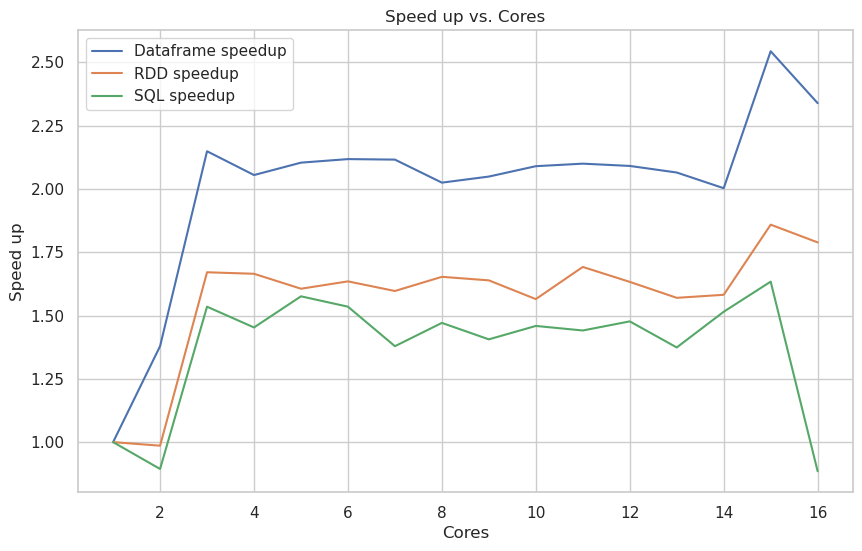

In [89]:
#Visualizacion
plt.figure(figsize=(10, 6))
sns.lineplot(x='cores', y='dataframe_speedup', data=df_3, label='Dataframe speedup')
sns.lineplot(x='cores', y='rdd_speedup', data=df_3, label='RDD speedup')
sns.lineplot(x='cores', y='sql_speedup', data=df_3, label='SQL speedup')

plt.xlabel('Cores')
plt.ylabel('Speed up')
plt.title('Speed up vs. Cores')

plt.legend()

plt.show()

Finalmente, el valor de speed up de las 3 implementaciones evidencia un gran incremento en su valor a partir de 2 cores. A partir del core 3, se ve una tendencia constante en todos los 3 metodos. No obstante, cuando el numero de cores es mayor a 14, se presentan cambios notorios, picos altos seguidos de valores bajos de speed up.

## Conclusiones general